In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import pickle

np.random.seed(951)
encoder = OneHotEncoder(sparse=False)

def load_batch(filename):
    """ Copied from the dataset website """
    with open('Datasets/' + filename, 'rb') as fo:
        dataset_dict = pickle.load(fo, encoding='bytes')
 
    return dataset_dict

def load(filename):
    data = load_batch(filename)
    
    X = data[b'data'].astype(np.float32).reshape(-1, 3072).T / 255
    y = np.array(data[b'labels']).astype(np.int32)
    
    Y = np.zeros((10, y.shape[0]), dtype=np.float32)
    for i, label in enumerate(y):
        Y[label, i] = 1
    
    return X, Y, y + 1

def softmax(x):
    """ Standard definition of the softmax function """
    return np.exp(x) / np.sum(np.exp(x), axis=0)




In [16]:
# Cyclical learning rate scheduler

class CyclicalLearningRate:
    def __init__(self, min_lr, max_lr, n_epochs, step_size):
        import math

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_epochs = n_epochs
        self.step_multiplier = 2
        self.cycle_multiplier = 3
        self.step_duration = self.step_multiplier * math.floor(step_size)
        self.time = 2 * self.cycle_multiplier * self.step_duration
        self.current_cycle = 1

    def __call__(self):
        self.time += 1
        if self.time > 2 * (self.cycle_multiplier + 1) * self.step_duration:
            self.cycle_multiplier += 1
            self.current_cycle += 1

        if (
            self.time >= 2 * self.cycle_multiplier * self.step_duration
        ) and (
            self.time <= (2 * self.cycle_multiplier + 1) * self.step_duration
        ):
            lr = self.min_lr + 1 / self.step_duration * (
                self.time - 2 * self.cycle_multiplier * self.step_duration
            ) * (self.max_lr - self.min_lr)
            return lr

        elif (
            self.time >= (2 * self.cycle_multiplier + 1) * self.step_duration
        ) and (
            self.time <= 2 * (self.cycle_multiplier + 1) * self.step_duration
        ):
            lr = self.max_lr - 1 / self.step_duration * (
                self.time - (2 * self.cycle_multiplier + 1) * self.step_duration
            ) * (self.max_lr - self.min_lr)
            return lr

        else:
            raise ValueError("Issue in cyclical learning rate calculation")

In [17]:
def normalize_data(train, validation, test):
    # Compute the mean and standard deviation of the training data
    train_mean = np.mean(train, axis=1, keepdims=True)
    train_std = np.std(train, axis=1, keepdims=True)

    # Normalize the training, validation and test data
    train_norm = (train - train_mean) / train_std
    validation_norm = (validation - train_mean) / train_std
    test_norm = (test - train_mean) / train_std

    return train_norm, validation_norm, test_norm


train_X, train_Y, train_y = load('data_batch_1')
val_X, val_Y, val_y = load('data_batch_2')
test_X, test_Y, test_y = load('test_batch')

train_X_norm, val_X_norm, test_X_norm = normalize_data(train_X, val_X, test_X)

def initialize_parameters(K, d, m):
    W1 = np.random.randn(m, d) * (1 / np.sqrt(d))
    b1 = np.zeros((m, 1))
    W2 = np.random.randn(K, m) * (1 / np.sqrt(m))
    b2 = np.zeros((K, 1))
    return W1, b1, W2, b2


def forward_pass(X, W1, b1, W2, b2):
    S1 = np.dot(W1, X) + b1
    H = np.maximum(0, S1)
    S = np.dot(W2, H) + b2
    P = softmax(S)
    return H, P

K = 10
m = 50
d = 3072


W1, b1, W2, b2 = initialize_parameters(K, d, m)



def ComputeCost(X, Y, W1, b1, W2, b2, lamda):
    _, P = forward_pass(X, W1, b1, W2, b2)
    loss = -np.mean(np.sum(Y * np.log(P), axis=0))
    reg = lamda * (np.sum(W1 * W1) + np.sum(W2 * W2))
    cost = loss + reg

    return cost, loss

def ComputeAccuracy(X, y, W1, b1, W2, b2):
    _, P = forward_pass(X, W1, b1, W2, b2)
    y_predicted = np.argmax(P, axis=0)
    return np.sum(y_predicted == y) / len(y)

def ComputeGradients(X, Y, W1, b1, W2, b2, lamda):
    N = X.shape[1]
    H, P = forward_pass(X, W1, b1, W2, b2)
    G = -(Y - P)
    grad_W2 = np.dot(G, H.T) / N + 2 * lamda * W2
    grad_b2 = np.sum(G, axis=1, keepdims=True) / N

    G = np.matmul(W2.T, G)
    G[H <= 0.0] = 0.0
    grad_W1 = np.matmul(G, X.T) / N + 2 * lamda * W1
    grad_b1 = np.sum(G, axis=1).reshape(-1, 1) / N
    return grad_W1, grad_b1, grad_W2, grad_b2

def ComputeGradientNum(X,Y, W1, b1, W2, b2, lamda, h=1e-6):
    grad_w1 = np.zeros(W1.shape)
    grad_w2 = np.zeros(W2.shape)
    grad_b1 = np.zeros(b1.shape)
    grad_b2 = np.zeros(b2.shape)

    c, _ = ComputeCost(X, Y, W1, b1, W2, b2, lamda)

    for i in range(len(b1)):
        b1[i] += h
        c2, _ = ComputeCost(X, Y, W1, b1, W2, b2, lamda)
        grad_b1[i] = (c2 - c) / h
        b1[i] -= h

    for i in range(len(b2)):
        b2[i] += h
        c2 , _= ComputeCost(X, Y, W1, b1, W2, b2, lamda)
        grad_b2[i] = (c2 - c) / h
        b2[i] -= h

    for i in range(len(W1)):
        for j in range(len(W1[0])):
            W1[i][j] += h
            c2 , _= ComputeCost(X, Y, W1, b1, W2, b2, lamda)
            grad_w1[i][j] = (c2 - c) / h
            W1[i][j] -= h

    for i in range(len(W2)):
        for j in range(len(W2[0])):
            W2[i][j] += h
            c2 , _= ComputeCost(X, Y, W1, b1, W2, b2, lamda)
            grad_w2[i][j] = (c2 - c) / h
            W2[i][j] -= h

    return grad_w1, grad_b1, grad_w2, grad_b2


In [18]:
X_small = train_X_norm[:, :100]
Y_small = train_Y[:, :100]
lamda = 0

grad_W1, grad_b1, grad_W2, grad_b2 = ComputeGradients(X_small, Y_small, W1, b1, W2, b2, lamda)

grad_W1_num, grad_b1_num, grad_W2_num, grad_b2_num = ComputeGradientNum(X_small, Y_small, W1, b1, W2,b2, lamda)

print("grad_W1: ", np.max(np.abs(grad_W1 - grad_W1_num)))
print("grad_W2: ", np.max(np.abs(grad_W2 - grad_W2_num)))
print("grad_B1: ", np.max(np.abs(grad_b1 - grad_b1_num)))
print("grad_B2: ", np.max(np.abs(grad_b2 - grad_b2_num)))

grad_W1:  1.2992952429236038e-08
grad_W2:  1.1560253793119202e-07
grad_B1:  9.464582485796402e-09
grad_B2:  6.568058046052538e-08


Final training cost: 0.004403790060531445
Final validation cost: 3.8616293155165566


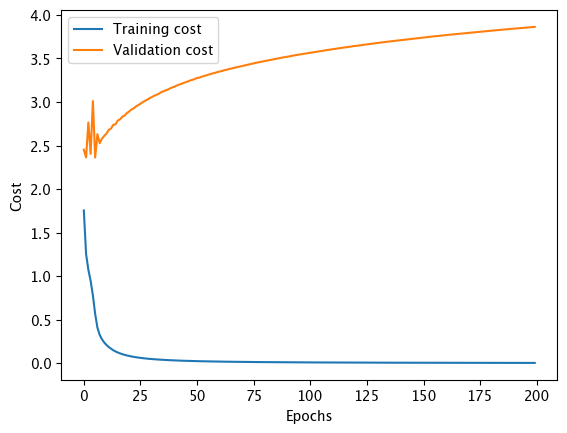

In [19]:
def train_mini(X, Y, X_validation, Y_validation, n_batch, eta, n_epochs, W1, b1, W2, b2, lamda):
    n = X.shape[1]
    costs = []
    val_costs = []

    for epoch in range(n_epochs):
        for j in range(n//n_batch):
            j_start = j * n_batch
            j_end = (j + 1) * n_batch
            X_batch = X[:, j_start:j_end]
            Y_batch = Y[:, j_start:j_end]

            grad_W1, grad_b1, grad_W2, grad_b2 = ComputeGradients(X_batch, Y_batch, W1, b1, W2, b2, lamda)

            W1 -= eta * grad_W1
            b1 -= eta * grad_b1
            W2 -= eta * grad_W2
            b2 -= eta * grad_b2
        costs.append(ComputeCost(X, Y, W1, b1, W2, b2, lamda)[0])
        val_costs.append(ComputeCost(X_validation, Y_validation, W1, b1, W2, b2, lamda)[0])

    return W1, b1, W2, b2, costs, val_costs

n_batch = 100
eta = 0.1
n_epochs = 200
X_val_small = val_X_norm[:, :100]
Y_val_small = val_Y[:, :100]

W1, b1, W2, b2, costs, val_costs = train_mini(X_small, Y_small, X_val_small, Y_val_small, n_batch, eta, n_epochs, W1, b1, W2,b2, lamda)

print("Final training cost:", costs[-1])
print("Final validation cost:", val_costs[-1])

#plot the training and validation cost
plt.plot(costs, label='Training cost')
plt.plot(val_costs, label='Validation cost')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.legend()
plt.show()

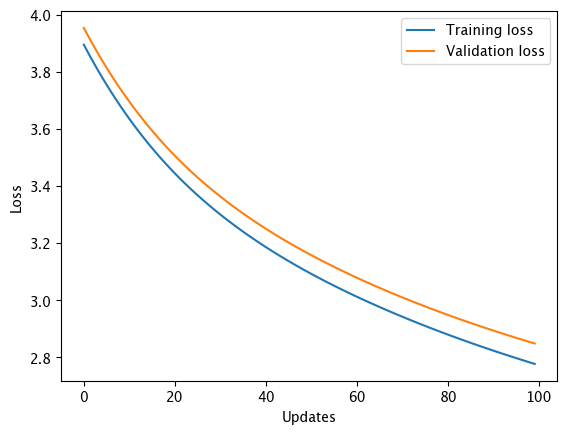

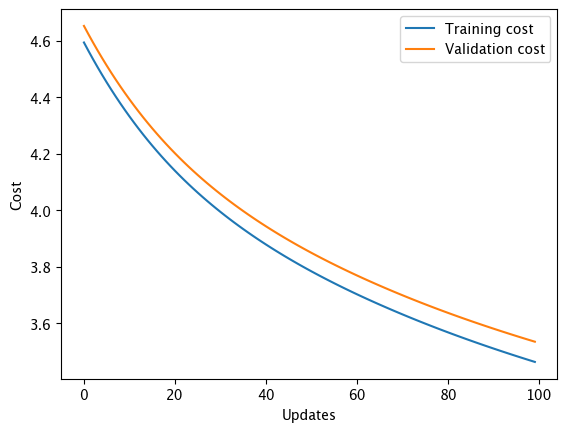

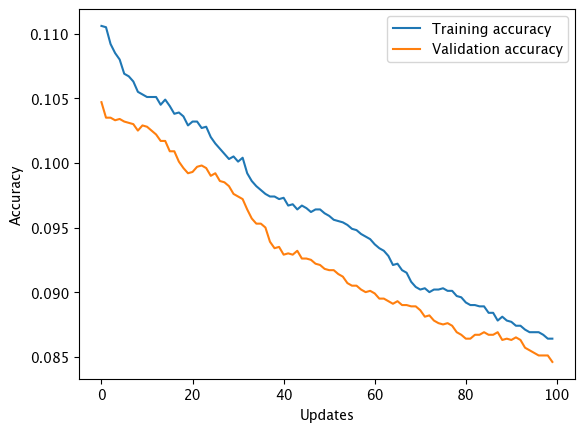

Final training loss: 0.0864


In [20]:
def apply_update(W1, b1, W2, b2, grad_w1, grad_b1, grad_w2, grad_b2, learning_rate):
    W1 -= learning_rate * grad_w1
    W2 -= learning_rate * grad_w2
    b1 -= learning_rate * grad_b1
    b2 -= learning_rate * grad_b2
    return W1, b1, W2, b2,

def train_cyclical(X, Y, X_validation, Y_validation, n_batch, eta_min, eta_max, n_epochs, W1, b1, W2, b2, lamda, y_train, y_val):
    losses = []
    val_losses = []
    costs = []
    val_costs = []
    accuracies = []
    val_accuracies = []
    eta_list = []
    N = X.shape[1]
    t=0

    steps = X.shape[1] // n_batch

    for epoch in range(100):
        for j in range(steps):
            t = t % (2 * N//n_batch)
            if t <= N//n_batch:
                lr = eta_min + t * (eta_max - eta_min) / (N//n_batch)
            else:
                lr = eta_max - (t - N//n_batch) * (eta_max - eta_min) / (N//n_batch)



            j_start = j * n_batch
            j_end = (j + 1) * n_batch
            X_batch = X[:, j_start:j_end]
            Y_batch = Y[:, j_start:j_end]

            grad_W1, grad_b1, grad_W2, grad_b2 = ComputeGradients(X_batch, Y_batch, W1, b1, W2, b2, lamda)

            #W1, b1, W2, b2 = apply_update(W1, b1, W2, b2, grad_W1, grad_b1, grad_W2, grad_b2, lr)
            W1 -= lr * grad_W1
            b1 -= lr * grad_b1
            W2 -= lr * grad_W2
            b2 -= lr * grad_b2

        
        losses.append(ComputeCost(X, Y, W1, b1, W2, b2, lamda)[1])
        val_losses.append(ComputeCost(X_validation, Y_validation, W1, b1, W2, b2, lamda)[1])
        costs.append(ComputeCost(X, Y, W1, b1, W2, b2, lamda)[0])
        val_costs.append(ComputeCost(X_validation, Y_validation, W1, b1, W2, b2, lamda)[0])
        accuracies.append(ComputeAccuracy(X, y_train, W1, b1, W2, b2))
        val_accuracies.append(ComputeAccuracy(X_validation, y_val, W1, b1, W2, b2))



    return W1, b1, W2, b2, costs, val_costs, losses, val_losses, accuracies, val_accuracies


n = train_X_norm.shape[1]
n_batch = 100
eta_min = 1e-5
eta_max = 1e-1
n_s = 2 * (n // n_batch)
n_epochs = 500
lamda = 0.01

W1, b1, W2, b2, costs, val_costs, losses, val_losses, accuracies, val_accuracies = train_cyclical(train_X_norm, train_Y, val_X_norm, val_Y,n_batch, eta_min, eta_max,n_epochs, W1, b1, W2, b2, lamda, train_y, val_y)



plt.plot(losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Updates')
plt.ylabel('Loss')
plt.legend()
plt.show()



# Plot the training and validation cost
plt.plot(costs, label='Training cost')
plt.plot(val_costs, label='Validation cost')
plt.xlabel('Updates')
plt.ylabel('Cost')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(accuracies, label='Training accuracy')
plt.plot(val_accuracies, label='Validation accuracy')
plt.xlabel('Updates')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Print the final training loss
print("Final training loss:", accuracies[-1])
